<h1 align="center" style="margin-top:10px">Boosting</h1>

# Setting

In [1]:
# Load dataset
#!pip3 install --upgrade oauth2client
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Please upload your csv on your google drive, give access to anyone, copy the link, and update the file ID and name.
google_docs = {
    '10EKrWLtL-Qqxyje4hyYtdj1eTVfihpoE' : 'clean_bank_Boost.csv',
    '13I9vgQ7InKF1-PfGXIIVBhSR0aaqjfOH' : 'clean_bank_train_Boost.csv',
    '1Bk9wFYStJPbXKtzi_DcawyzWF3Vo7rCq' : 'clean_bank_test_Boost.csv',
    '1j7HOEKLZctvRBl14vtglzYYzT-PIsiJd' : 'tutorial7.py',
    '1bQhKWLDYYW3NYGxYfY506B6lJ7Mk9G6Y' : 'tutorial2.py'

}


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for key in google_docs:
  drive.CreateFile({'id':key}).GetContentFile(google_docs[key])

In [2]:
#!pip install cartopy
!pip install catboost
!pip install optuna
!pip install category_encoders
!pip install shap
#!pip install xgboost
#!pip install lightgbm
#!pip install pygam==0.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.9 MB/s eta 0:00:00


In [3]:
# Requirements 
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import cartopy
import sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost
import optuna
import sys

from sklearn.model_selection import train_test_split

from tutorial7 import plot_feature_importance

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'seaborn {sns.__version__}')
# print(f'cartopy {cartopy.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'xgboost {xgb.__version__}')
print(f'lightgbm {lgb.__version__}')
print(f'catboost {catboost.__version__}')
print(f'optuna {optuna.__version__}')

# Notebook tested on:

# numpy 1.23.5
# scipy 1.10.0
# pandas 1.5.2
# seaborn 0.12.2
# cartopy 0.21.1
# scikit-learn 1.2.0
# xgboost 1.6.1
# lightgbm 3.3.2
# catboost 1.0.6
# optuna 2.10.1


# Optional configuration

# This is to clear the warnings from the notebook, usually we should leave this on


Package versions: 

numpy 1.22.4
scipy 1.10.1
pandas 1.5.3
seaborn 0.12.2
scikit-learn 1.2.2
xgboost 1.7.5
lightgbm 3.3.5
catboost 1.2
optuna 3.1.1


In [4]:
import warnings
warnings.filterwarnings('ignore') 

# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
plt.rcParams['figure.dpi'] = 80
%config InlineBackend.figure_format = 'retina'


In [5]:
# Funtions

def plot_feature_importance(model, labels, max_features = 20):
    feature_importance = model.feature_importances_*100
    # feature_importance = model.feature_importance(importance_type='gain')
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax

def booster_plot_feature_importance(model, labels, max_features = 20):
    # feature_importance = model.feature_importances_*100
    feature_importance = model.feature_importance(importance_type='gain')
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax



def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total Actuall Subscribed: ', np.sum(cm[1]))

In [6]:
# One hot encoding
train1_v = pd.read_csv('clean_bank_train_Boost.csv')
test1 = pd.read_csv('clean_bank_test_Boost.csv')

train1_v = train1_v.drop(['job','marital','education','default',
                     'housing','loan','contact','month',
                     'day_of_week','pdays','previous','poutcome'], axis=1).copy()


test1 = test1.drop(['job','marital','education','default',
                     'housing','loan','contact','month',
                     'day_of_week','pdays','previous','poutcome'], axis=1).copy()



index_train1, index_valid1 = train_test_split(train1_v.index, train_size=0.8, random_state=7)

train1 = train1_v.loc[index_train1, :].copy()
valid1 = train1_v.loc[index_valid1, :].copy()



X_train1 = train1.loc[:, train1.columns!='y']
X_valid1 = valid1.loc[:, valid1.columns!='y']
X_test1 = test1.loc[:, test1.columns!='y']

predictors1 = list(X_train1.columns)


y_train1 = train1['y']
y_valid1 = valid1['y']
y_test1 = test1['y']

In [7]:
# Without encoding
bank = pd.read_csv('clean_bank_Boost.csv')

index_train_v, index_test = train_test_split(bank.index, train_size=0.7, random_state=7)


train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='y']
X_valid = valid.loc[:, test.columns!='y']
X_test = test.loc[:, test.columns!='y']

# predictors = list(X_train.columns)

y_train = train['y']
y_valid = valid['y']
y_test = test['y']

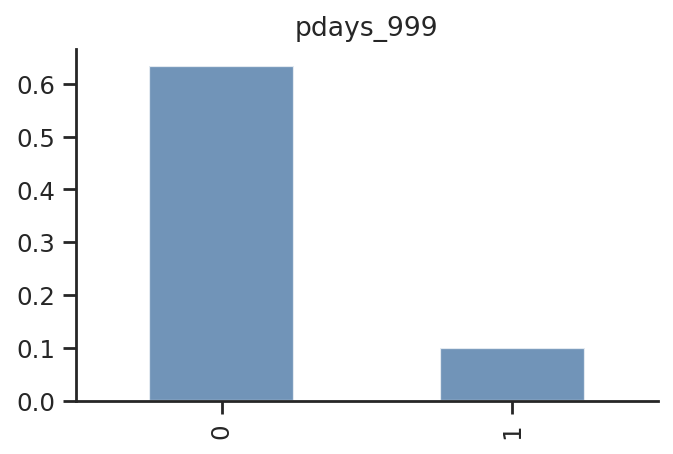

In [8]:
from tutorial2 import crosstabplots
crosstabplots(train1[['pdays_999']], y_train1)
plt.show()

# Benchmark models - One-Hot encoding


##  Gradient boosting

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, n_estimators= 1901, subsample = 0.596
                                )
gb.fit(X_train1, y_train1)

CPU times: user 35.5 s, sys: 84.4 ms, total: 35.6 s
Wall time: 47.3 s


GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=1901,
                           subsample=0.596)

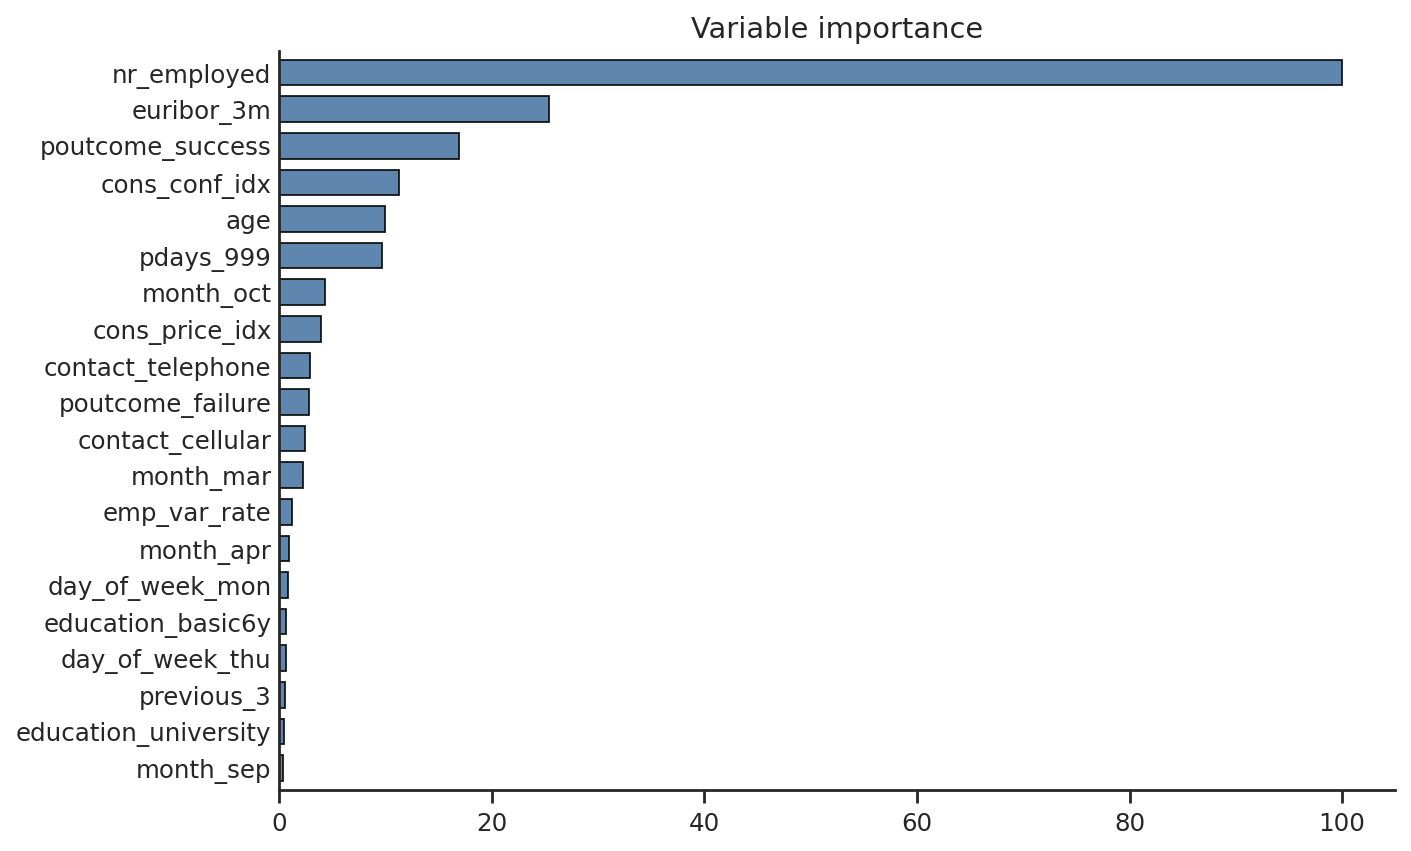

In [ ]:
# Importance
from tutorial7 import plot_feature_importance
plot_feature_importance(gb, predictors1)
plt.show()

## HistGradientBoosting

In [ ]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(learning_rate = 0.01, max_depth = 8, max_iter = 1901)

hgb.fit(X_train1, y_train1)

CPU times: user 6.14 s, sys: 82.6 ms, total: 6.23 s
Wall time: 3.27 s


HistGradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_iter=1901)

## XGBoost

In [ ]:
%%time

import xgboost as xgb

xgbst = xgb.XGBClassifier(objective='binary:logistic', booster = 'gbtree', learning_rate = 0.02, 
                        max_depth = 6, n_estimators = 1822, subsample = 0.60,  reg_lambda=0.0, 
                        reg_alpha = 0.0, colsample_bytree = 1.0, min_child_weight = 1.0
                        )

# n_estimators: number of trees
# subsample: fraction of observations used to fit each tree
# reg_lambda: L2 regularisation penalty
# reg_alpha: L1 regularisation penalty
# colsample_bytree: fraction of features considered for each tree (alternatives: bylevel, bynode)
# min_child_weight: approximately equal to the minimum number of samples in each node

xgbst.fit(X_train1, y_train1)

CPU times: user 3min 18s, sys: 568 ms, total: 3min 18s
Wall time: 1min 52s


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1.0, missing=nan, monotone_constraints=None,
              n_estimators=1822, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

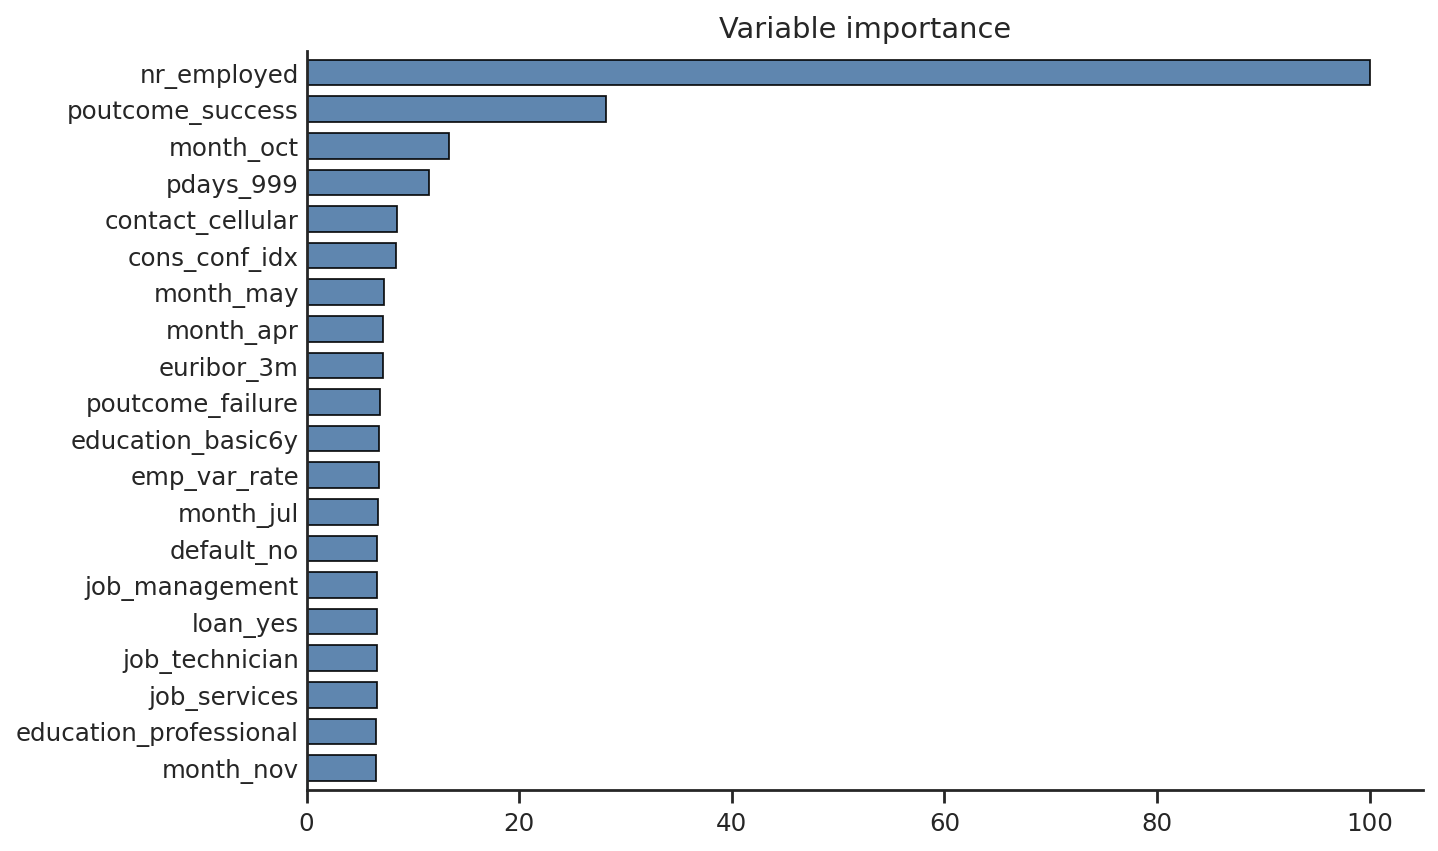

In [ ]:
plot_feature_importance(xgbst, labels=predictors1)
plt.show()

## CatBoost

In [ ]:
# One-hot
%%time
from catboost import CatBoostClassifier

cb = CatBoostClassifier(loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0
                      )
        
cb.fit(X_train1, y_train1)

# Important! If there were categorical features, you'd want to change the code to
# cb.fit(X_train, y_train, cat_features = cat_indices)
# where cat_indices is a one-dimensional array of indices indicating the categorical columns in X_train

CPU times: user 24.4 s, sys: 1.45 s, total: 25.8 s
Wall time: 14.7 s


In [ ]:
# With out encoding
%%time
from catboost import CatBoostClassifier

cb2 = CatBoostClassifier(loss_function='Logloss', 
                       iterations = 2000, learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0
                      )

cat_indices = [i for i, j in enumerate(X_train.dtypes) if j == "object"]
cb2.fit(X_train, y_train, cat_features = cat_indices)

CPU times: user 2min 26s, sys: 3.77 s, total: 2min 30s
Wall time: 1min 34s


## LightGBM

In [ ]:
# One-hot
%%time
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(objective='binary', boosting_type = 'gbdt', 
                         n_estimators = 1974, learning_rate = 0.01,  
                         num_leaves = 24,
                         lambda_l1 = 0.0, lambda_l2 = 0.0,
                         bagging_fraction = 0.74, bagging_freq = 1, 
                         feature_fraction = 1.0, min_data_in_leaf = 1,
                         random_state = 7,
                        )

lgbm = lgbm.fit(X_train1, y_train1)

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.74, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
CPU times: user 7.74 s, sys: 142 ms, total: 7.88 s
Wall time: 4.55 s


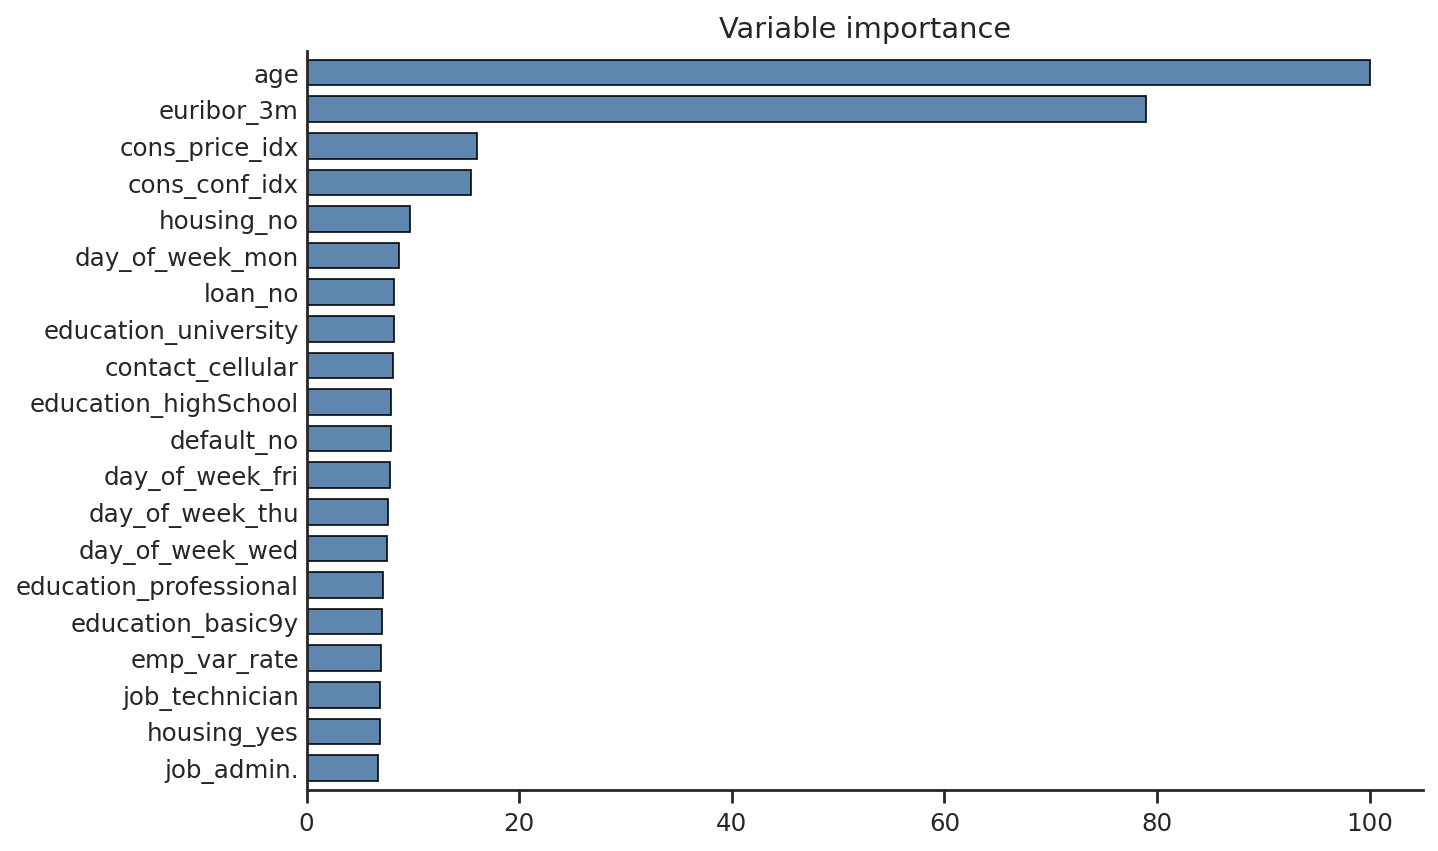

In [ ]:
plot_feature_importance(lgbm, labels=predictors1)
plt.show()

## Validation results

In [ ]:
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

columns=['Sensitivity', 'F1-score','Error Rate', 
         'Specificity', 'Precision', 'AUC', 'Cross-entropy']

rows=['GBM', 'Histogram-based GBM',
      'XGBoost', 'CatBoost',  'LightGBM',
      'CatBoost without encoding'
      ]

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [gb, hgb, xgbst, cb, lgbm,
           cb2
           ]

y_prob1 = np.zeros((len(y_valid1), len(rows)))
y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):

    if method != methods[5]:
        y_prob1[:, i] = method.predict_proba(X_valid1)[:, 1]
        y_pred1 = method.predict(X_valid1)
        tn, fp, fn, tp = confusion_matrix(y_valid1, y_pred1).ravel()         
    
        results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
        results.iloc[i,1] =  f1_score(y_valid1, y_pred1)  #f1-score
        results.iloc[i,2] =   1 - accuracy_score(y_valid1, y_pred1)    # error rate
        results.iloc[i,3] =  tn/(tn+fp)  #specificity
        results.iloc[i,4] =  precision_score(y_valid1, y_pred1)  # precision
        results.iloc[i,5] =  roc_auc_score(y_valid1, y_prob1[:,i])  # AUC
        results.iloc[i,6] =  log_loss(y_valid1, y_prob1[:,i])   #Corss-entropy
    else:

        y_prob[:, 0] = method.predict_proba(X_valid)[:, 1]
        y_pred = method.predict(X_valid)
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()

        results.iloc[i,0] =  tp/(tp+fn)  # sensitivity
        results.iloc[i,1] =  f1_score(y_valid, y_pred)  #f1-score
        results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)    # error rate
        results.iloc[i,3] =  tn/(tn+fp)  #specificity
        results.iloc[i,4] =  precision_score(y_valid, y_pred)  # precision
        results.iloc[i,5] =  roc_auc_score(y_valid, y_prob[:,0])  # AUC
        results.iloc[i,6] =  log_loss(y_valid, y_prob[:,0])   #Corss-entropy


   

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

,Sensitivity,F1-score,Error Rate,Specificity,Precision,AUC,Cross-entropy
XGBoost,0.270,0.366,0.116,0.971,0.567,0.753,0.327
LightGBM,0.259,0.369,0.110,0.980,0.645,0.777,0.300
CatBoost,0.248,0.357,0.111,0.980,0.637,0.773,0.303
CatBoost without encoding,0.240,0.355,0.108,0.984,0.680,0.782,0.297
GBM,0.223,0.338,0.109,0.986,0.696,0.780,0.296
Histogram-based GBM,0.189,0.298,0.111,0.989,0.701,0.777,0.296


From the evaluation table above, we found XGBoost and LightGBM might be the best candidates for the reason that we value the cost of false negative rate more and the two models have relatively high Sensitivity and f1-score.


# Feature engineering
- LightGBM
- XGBoost

In [9]:
# Without encoding
bank = pd.read_csv('clean_bank_Boost.csv')

index_train_v, index_test = train_test_split(bank.index, train_size=0.7, random_state=7)


train_v = bank.loc[index_train_v, :].copy()
test = bank.loc[index_test, :].copy()

index_train, index_valid = train_test_split(train_v.index, train_size=0.8, random_state=7)

train = train_v.loc[index_train, :].copy()
valid = train_v.loc[index_valid, :].copy()


X_train = train.loc[:, train.columns!='y'].copy()
X_valid = valid.loc[:, test.columns!='y'].copy()
X_test = test.loc[:, test.columns!='y'].copy()

predictors = list(X_train.columns)

y_train = train['y']
y_valid = valid['y']
y_test = test['y']

In [10]:
nominal = list(X_train.columns[X_train.dtypes == "object"])
features = list(X_train.columns[X_train.dtypes != "object"])

## One-hot encoding for binary variables


In [11]:
binary = ['default','housing','loan','poutcome','contact']

variable = binary


dummies = pd.get_dummies(bank[variable])


train = train.join(dummies.loc[index_train, :])
valid = valid.join(dummies.loc[index_valid, :])
test = test.join(dummies.loc[index_test, :])


train = train.drop(variable, axis=1).copy()
valid = valid.drop(variable, axis=1).copy()
test = test.drop(variable, axis=1).copy()

binary_dummies = list(dummies.columns)

## Convert all categories to compare

In [12]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.glmm import GLMMEncoder
from category_encoders.cat_boost import CatBoostEncoder

In [13]:
continuous = ['age', 'pdays', 'emp_var_rate','cons_price_idx',
                 'cons_conf_idx','euribor_3m','nr_employed']

nominal = ['job', 'marital', 'month', 'day_of_week']

binary = ['default','housing','loan','poutcome','contact']

discrete = ['previous']

ordinal = ['education']

response = ['y']

In [14]:
# We dont encode the discrete values because decision trees take a range anyways so we dont have to.

nominal = ['job', 'marital', 'education', 'month', 'day_of_week']

for x in nominal:
    # Target encoder
    encoder = TargetEncoder().fit(train[x], y_train) # we must use the training set for this
    train[x+'TE'] = encoder.transform(train[x])
    valid[x+'TE'] = encoder.transform(valid[x])
    test[x+'TE'] = encoder.transform(test[x])


    # Leave one out encoder
    encoder = LeaveOneOutEncoder().fit(train[x], y_train) 
    train[x+'LeaveOneOut'] = encoder.transform(train[x])
    valid[x+'LeaveOneOut'] = encoder.transform(valid[x])
    test[x+'LeaveOneOut'] = encoder.transform(test[x])

    # GLMM encoder
    encoder =  GLMMEncoder().fit(train[x], y_train)
    train[x+'GLMM'] = encoder.transform(train[x])
    valid[x+'GLMM'] = encoder.transform(valid[x])
    test[x+'GLMM'] = encoder.transform(test[x])

    # CatBoostEncoder
    encoder = CatBoostEncoder().fit(train[x], y_train) 
    train[x+'CatBoost'] = encoder.transform(train[x])
    valid[x+'CatBoost'] = encoder.transform(valid[x])
    test[x+'CatBoost'] = encoder.transform(test[x])
    
    # One-hot encoder
    dummies = pd.get_dummies(bank[x],  prefix = x)
    train = train.join(dummies.loc[index_train, :])
    valid = valid.join(dummies.loc[index_valid, :])
    test = test.join(dummies.loc[index_test, :])
    globals()['%s_OneHot' % x] = list(dummies.columns)

In [15]:
# Ordinal - education
keys = {
        'unknown' : 0,
        'basic4y' : 1, 
        'basic6y' : 2,
        'basic9y' : 3, 
        'highSchool' : 4, 
        'professional' : 5, 
        'university' : 6
}


variable = 'education'

train['educationOrdinal'] = train[variable].replace(keys).astype(int)
valid['educationOrdinal'] = valid[variable].replace(keys).astype(int)
test['educationOrdinal'] = test[variable].replace(keys).astype(int)

In [ ]:
features

['age',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor_3m',
 'nr_employed',
 'pdays_999']

In [ ]:
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

def test_encodings(algo, variables):

  results_df_dic = {}
  for x in nominal:

      rows = ['One-Hot encoding', 'Target encoder', 'Leave-one-out encoder', 
              'GLMM encoder', 'CatBoost encoder', 'Ordinal encoder']

      columns=['F1-score','Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision']

      results = pd.DataFrame(0.0, columns=columns, index=rows)
    

      y_prob = np.zeros((len(y_valid), len(rows)))
      for i in range(len(rows)):
        if i == 5 and x != 'education':
          continue
        feature = []
        if i==0:
            feature = variables + globals()['%s_OneHot' % x]
        elif i==1: 
            feature = variables + [x+'TE'] 
        elif i==2:
            feature = variables + [x+'LeaveOneOut']
        elif i==3: 
            feature = variables + [x+'GLMM']
        elif i==4: 
            feature = variables + [x+'CatBoost']  
        if x == 'education':
          if i==5:
            feature = variables + ['educationOrdinal']
        
        X_train = train[feature]
        X_valid = valid[feature]
        model = algo
        model.fit(X_train, y_train)

        # validation set predictions
        
        y_prob[:, i] = model.predict_proba(X_valid)[:, 1]
        y_pred = model.predict(X_valid)
              
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

        results.iloc[i,0] =  f1_score(y_valid, y_pred)  #f1-score
        results.iloc[i,1] =  log_loss(y_valid, y_prob[:,i])   # Cross entropy
        results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
        results.iloc[i,3] =  roc_auc_score(y_valid, y_prob[:,i])   # AUC
        results.iloc[i,4] =  tp/(tp+fn)   # Sensitivity 
        results.iloc[i,5] =  tn/(tn+fp)   # Specificity	
        results.iloc[i,6] =  precision_score(y_valid, y_pred)   # Precision
        


      if x not in results_df_dic:
          results_df_dic[x] = results
  return results_df_dic

## Best encoding for XGBoost

In [ ]:
%%time
import xgboost as xgb
xgbst = xgb.XGBClassifier(objective='binary:logistic', booster = 'gbtree', learning_rate = 0.02, 
                        max_depth = 6, n_estimators = 1822, subsample = 0.60,  reg_lambda=0.0, 
                        reg_alpha = 0.0, colsample_bytree = 1.0, min_child_weight = 1.0
                        )

CPU times: user 38 µs, sys: 27 µs, total: 65 µs
Wall time: 68.9 µs


In [ ]:
results_df_dic = test_encodings(xgbst, features)

In [ ]:
for key in results_df_dic:
    print(key)
    display(results_df_dic[key].sort_values(by=['F1-score'], ascending = [0]).round(5))

job


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Target encoder,0.32711,0.32966,0.11802,0.74484,0.23101,0.97428,0.56015
Leave-one-out encoder,0.32711,0.32966,0.11802,0.74484,0.23101,0.97428,0.56015
CatBoost encoder,0.32711,0.32966,0.11802,0.74484,0.23101,0.97428,0.56015
GLMM encoder,0.32456,0.32937,0.11860,0.74519,0.22946,0.97384,0.55431
One-Hot encoding,0.31637,0.32827,0.11898,0.74699,0.22171,0.97450,0.55212
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


marital


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Target encoder,0.33846,0.32522,0.11590,0.75097,0.23876,0.97560,0.58113
Leave-one-out encoder,0.33846,0.32522,0.11590,0.75097,0.23876,0.97560,0.58113
CatBoost encoder,0.33846,0.32522,0.11590,0.75097,0.23876,0.97560,0.58113
One-Hot encoding,0.33333,0.32620,0.11706,0.74978,0.23566,0.97472,0.56929
GLMM encoder,0.32640,0.32531,0.11841,0.75260,0.23101,0.97384,0.55597
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


education


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.33149,0.32991,0.11648,0.74301,0.23256,0.97582,0.57692
Target encoder,0.32967,0.32821,0.11744,0.74718,0.23256,0.97472,0.56604
Leave-one-out encoder,0.32967,0.32821,0.11744,0.74718,0.23256,0.97472,0.56604
GLMM encoder,0.32967,0.32821,0.11744,0.74718,0.23256,0.97472,0.56604
CatBoost encoder,0.32967,0.32821,0.11744,0.74718,0.23256,0.97472,0.56604
Ordinal encoder,0.32486,0.32911,0.11764,0.74580,0.22791,0.97516,0.56538


default


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Leave-one-out encoder,0.32780,0.32726,0.11687,0.74829,0.22946,0.97582,0.57364
CatBoost encoder,0.32780,0.32726,0.11687,0.74829,0.22946,0.97582,0.57364
One-Hot encoding,0.32301,0.32793,0.11783,0.74764,0.22636,0.97516,0.56371
GLMM encoder,0.32301,0.32793,0.11783,0.74764,0.22636,0.97516,0.56371
Target encoder,0.32151,0.32806,0.11783,0.74723,0.22481,0.97538,0.56420
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


housing


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Target encoder,0.32044,0.33137,0.11841,0.74090,0.22481,0.97472,0.55769
Leave-one-out encoder,0.32044,0.33137,0.11841,0.74090,0.22481,0.97472,0.55769
GLMM encoder,0.32044,0.33137,0.11841,0.74090,0.22481,0.97472,0.55769
CatBoost encoder,0.32044,0.33137,0.11841,0.74090,0.22481,0.97472,0.55769
One-Hot encoding,0.31579,0.33339,0.12014,0.73931,0.22326,0.97296,0.53933
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


loan


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
GLMM encoder,0.31672,0.33000,0.11879,0.74740,0.22171,0.97472,0.55426
Target encoder,0.31637,0.32966,0.11898,0.74804,0.22171,0.97450,0.55212
Leave-one-out encoder,0.31637,0.32966,0.11898,0.74804,0.22171,0.97450,0.55212
CatBoost encoder,0.31637,0.32966,0.11898,0.74804,0.22171,0.97450,0.55212
One-Hot encoding,0.31299,0.32997,0.11918,0.74641,0.21860,0.97472,0.55078
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


contact


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.34385,0.32347,0.1161,0.75542,0.24496,0.9745,0.57664
Target encoder,0.34385,0.32347,0.1161,0.75542,0.24496,0.9745,0.57664
Leave-one-out encoder,0.34385,0.32347,0.1161,0.75542,0.24496,0.9745,0.57664
GLMM encoder,0.34385,0.32347,0.1161,0.75542,0.24496,0.9745,0.57664
CatBoost encoder,0.34385,0.32347,0.1161,0.75542,0.24496,0.9745,0.57664
Ordinal encoder,0.00000,0.00000,0.0000,0.00000,0.00000,0.0000,0.00000


month


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.32230,0.32771,0.11821,0.74698,0.22636,0.97472,0.55939
Target encoder,0.31416,0.32789,0.11937,0.74712,0.22016,0.97428,0.54826
Leave-one-out encoder,0.31416,0.32789,0.11937,0.74712,0.22016,0.97428,0.54826
GLMM encoder,0.31416,0.32769,0.11937,0.74738,0.22016,0.97428,0.54826
CatBoost encoder,0.31416,0.32789,0.11937,0.74712,0.22016,0.97428,0.54826
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


day_of_week


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.34586,0.32748,0.11725,0.74624,0.24961,0.97252,0.56294
Target encoder,0.33515,0.32689,0.11764,0.74733,0.23876,0.97362,0.56204
Leave-one-out encoder,0.33515,0.32689,0.11764,0.74733,0.23876,0.97362,0.56204
GLMM encoder,0.33515,0.32689,0.11764,0.74733,0.23876,0.97362,0.56204
CatBoost encoder,0.33515,0.32689,0.11764,0.74733,0.23876,0.97362,0.56204
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


poutcome


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.33259,0.32619,0.11590,0.74699,0.23256,0.97648,0.58366
Target encoder,0.32703,0.32673,0.11648,0.74584,0.22791,0.97648,0.57874
Leave-one-out encoder,0.32703,0.32673,0.11648,0.74584,0.22791,0.97648,0.57874
GLMM encoder,0.32703,0.32673,0.11648,0.74584,0.22791,0.97648,0.57874
CatBoost encoder,0.32703,0.32673,0.11648,0.74584,0.22791,0.97648,0.57874
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


XGBoost
- job: CatBoost
- marital: CatBoost
- education: One-hot
- month: One-hot
- day_of_week: One-hot

In [ ]:
continuous = ['age', 'pdays', 'emp_var_rate','cons_price_idx',
                 'cons_conf_idx','euribor_3m','nr_employed']
ordinal = ['education']
nominal = ['job', 'marital', 'month', 'day_of_week']
discrete = ['previous']
binary = ['default','housing','loan','poutcome','contact']

binary_ind = ['pdays_999']

# job: CatBoost
# marital: CatBoost
# education: One-hot
# month: One-hot
# day_of_week: One-hot


xgBoost_features = features  + ['jobCatBoost','maritalCatBoost'] + education_OneHot + month_OneHot + day_of_week_OneHot + binary_dummies 

## Best encoding for LightGBM

In [ ]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(objective='binary', boosting_type = 'gbdt', 
                         n_estimators = 1974, learning_rate = 0.01,  
                         num_leaves = 24,
                         lambda_l1 = 0.0, lambda_l2 = 0.0,
                         bagging_fraction = 0.74, bagging_freq = 1, 
                         feature_fraction = 1.0, min_data_in_leaf = 1,
                         random_state = 7
                          )

In [ ]:
results_df_dic = test_encodings(lgbm, features)

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.74, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=0.74, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current valu

In [ ]:
for key in results_df_dic:
    print(key)
    display(results_df_dic[key].sort_values(by=['F1-score'], ascending = [0]).round(5))

job


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.33371,0.30700,0.11302,0.76866,0.22791,0.98044,0.62288
GLMM encoder,0.32309,0.30801,0.11456,0.76807,0.22016,0.97978,0.60684
Target encoder,0.32229,0.30817,0.11417,0.76709,0.21860,0.98044,0.61304
Leave-one-out encoder,0.32229,0.30817,0.11417,0.76709,0.21860,0.98044,0.61304
CatBoost encoder,0.32229,0.30817,0.11417,0.76709,0.21860,0.98044,0.61304
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


marital


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Target encoder,0.32390,0.30925,0.11494,0.76897,0.22171,0.97912,0.60084
Leave-one-out encoder,0.32390,0.30925,0.11494,0.76897,0.22171,0.97912,0.60084
CatBoost encoder,0.32390,0.30925,0.11494,0.76897,0.22171,0.97912,0.60084
GLMM encoder,0.32236,0.30924,0.11494,0.76965,0.22016,0.97934,0.60169
One-Hot encoding,0.31782,0.30973,0.11571,0.76862,0.21705,0.97890,0.59322
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


education


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Ordinal encoder,0.32037,0.30966,0.11436,0.76703,0.21705,0.98044,0.61135
One-Hot encoding,0.31651,0.30908,0.11475,0.76593,0.21395,0.98044,0.60793
GLMM encoder,0.31300,0.30877,0.11494,0.76862,0.21085,0.98066,0.60714
Target encoder,0.31193,0.30914,0.11552,0.76771,0.21085,0.98000,0.59912
Leave-one-out encoder,0.31193,0.30914,0.11552,0.76771,0.21085,0.98000,0.59912
CatBoost encoder,0.31193,0.30914,0.11552,0.76771,0.21085,0.98000,0.59912


month


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
GLMM encoder,0.31435,0.31002,0.11590,0.76651,0.21395,0.97912,0.59227
Target encoder,0.31364,0.31008,0.11629,0.76627,0.21395,0.97868,0.58723
Leave-one-out encoder,0.31364,0.31008,0.11629,0.76627,0.21395,0.97868,0.58723
CatBoost encoder,0.31364,0.31008,0.11629,0.76627,0.21395,0.97868,0.58723
One-Hot encoding,0.31279,0.30991,0.11590,0.76767,0.21240,0.97934,0.59307
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


day_of_week


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.34119,0.30601,0.11302,0.76962,0.23566,0.97934,0.61789
Target encoder,0.32805,0.30647,0.11436,0.76867,0.22481,0.97934,0.60669
Leave-one-out encoder,0.32805,0.30647,0.11436,0.76867,0.22481,0.97934,0.60669
CatBoost encoder,0.32805,0.30647,0.11436,0.76867,0.22481,0.97934,0.60669
GLMM encoder,0.32463,0.30661,0.11456,0.76841,0.22171,0.97956,0.60593
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


- job: One-hot
- marital: CatBoost
- education: Ordinal
- month: GLMM
- day_of_week: One-hot

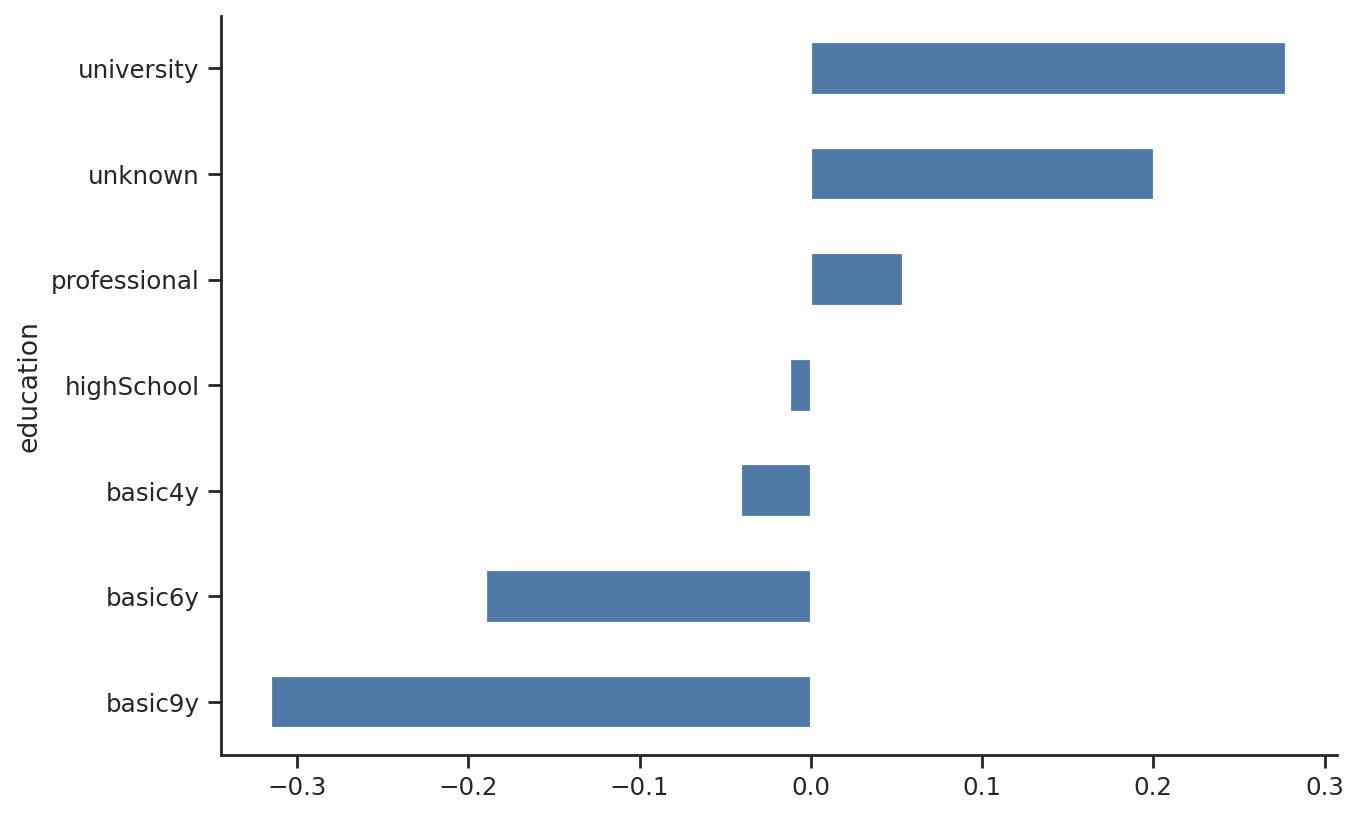

In [ ]:
train.groupby('month')['monthGLMM'].mean().sort_values().plot(kind='barh')
sns.despine()
plt.show()

In [ ]:
continuous = ['age', 'pdays', 'emp_var_rate','cons_price_idx',
                 'cons_conf_idx','euribor_3m','nr_employed']
ordinal = ['education']
nominal = ['job', 'marital', 'month', 'day_of_week']
discrete = ['previous']
binary = ['default','housing','loan','poutcome','contact']

binary_ind = ['pdays_999']

# job: One-hot
# marital: CatBoost
# education: Ordinal
# month: GLMM
# day_of_week: One-hot

lightGBM_features = features  + ['educationOrdinal', 'maritalCatBoost', 'monthGLMM'] + binary_ind + job_OneHot + day_of_week_OneHot + binary_dummies 

# XGBoost with encoding

In [22]:
xgBoost_features = features  + ['jobCatBoost','maritalCatBoost'] + education_OneHot + month_OneHot + day_of_week_OneHot + binary_dummies 

In [23]:
import xgboost as xgb

xgb_X_train = train[xgBoost_features].copy()
xgb_X_valid = valid[xgBoost_features].copy()
xgb_X_test = test[xgBoost_features].copy()



y_train = train['y']
y_valid = valid['y']
y_test = test['y']


# Assuming your features are stored in 'X' and labels in 'y'
xgb_train_data = xgb.DMatrix(xgb_X_train, label=y_train)
xgb_valid_data = xgb.DMatrix(xgb_X_valid, label=y_valid)
xgb_test_data = xgb.DMatrix(xgb_X_test, label=y_test)

## Hyperparameter tunning

In [ ]:
# We have to reconstruct the dataset to tune min_data_in_leaf
from optuna.samplers import TPESampler



def objective(trial):
    params = {
    'objective': 'binary:logistic',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01, 
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    'feature_pre_filter': False,
    'verbosity': 0
     }
    
    # Cross-validation 
    history = xgb.cv(params, xgb_train_data, num_boost_round = 1000, 
                     nfold = 10, stratified = False, early_stopping_rounds = 50, 
                     verbose_eval=False)


    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['test-logloss-mean']))
    
    return history['test-logloss-mean'].iloc[-1] # returns CV error for the best trial

sampler = TPESampler(seed = 7) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=2000, timeout = 3600)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2023-05-10 02:50:03,435] A new study created in memory with name: no-name-f3883fc7-5f93-43e3-9833-1ebd1595d43d
[I 2023-05-10 02:52:52,906] Trial 0 finished with value: 0.29441185055113295 and parameters: {'num_leaves': 6, 'lambda_l1': 0.10453678278574731, 'lambda_l2': 8.824357269705966e-05, 'bagging_fraction': 0.8617325889154706, 'bagging_freq': 10, 'feature_fraction': 0.7692479352052168, 'min_data_in_leaf': 65}. Best is trial 0 with value: 0.29441185055113295.
[I 2023-05-10 02:55:43,276] Trial 1 finished with value: 0.29441185055113295 and parameters: {'num_leaves': 6, 'lambda_l1': 2.605858448423918e-06, 'lambda_l2': 0.0003154586986665377, 'bagging_fraction': 0.8396149980604702, 'bagging_freq': 9, 'feature_fraction': 0.6904705665742692, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.29441185055113295.
[I 2023-05-10 02:58:33,903] Trial 2 finished with value: 0.29441185055113295 and parameters: {'num_leaves': 20, 'lambda_l1': 1.5358250592890428, 'lambda_l2': 8.326609203905651e

In [ ]:
xgb_params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
xgb_params

Number of boosting iterations: 423 

Best parameters:


{'objective': 'binary:logistic',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 6,
 'lambda_l1': 0.10453678278574731,
 'lambda_l2': 8.824357269705966e-05,
 'bagging_fraction': 0.8617325889154706,
 'bagging_freq': 10,
 'feature_fraction': 0.7692479352052168,
 'min_data_in_leaf': 65,
 'feature_pre_filter': False,
 'verbosity': 0}

## Performance








In [ ]:
# xgb_train_data = xgb.DMatrix(xgb_X_train, label=y_train)
# xgb_valid_data = xgb.DMatrix(xgb_X_valid, label=y_valid)
# xgb_test_data = xgb.DMatrix(xgb_X_test, label=y_test)

In [26]:
# Best parameters
import xgboost as xgb

#Number of boosting iterations: 423 
# Best parameters:
# {'objective': 'binary:logistic',
#  'boosting_type': 'gbdt',
#  'learning_rate': 0.01,
#  'num_leaves': 6,
#  'lambda_l1': 0.10453678278574731,
#  'lambda_l2': 8.824357269705966e-05,
#  'bagging_fraction': 0.8617325889154706,
#  'bagging_freq': 10,
#  'feature_fraction': 0.7692479352052168,
#  'min_data_in_leaf': 65,
#  'feature_pre_filter': False,
#  'verbosity': 0}

best_params = {'objective': 'binary:logistic',
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 6,
                'lambda_l1': 0.10453678278574731,
                'lambda_l2': 8.824357269705966e-05,
                'bagging_fraction': 0.8617325889154706,
                'bagging_freq': 10,
                'feature_fraction': 0.7692479352052168,
                'min_data_in_leaf': 65,
                'feature_pre_filter': False,
                'verbosity': 0}

best_xgbst = xgb.train(best_params, xgb_train_data, num_boost_round=1000)

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['XGBoost - Test']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[best_xgbst]

y_prob = np.zeros((len(y_test), len(rows)))

for i, method in enumerate(methods):
    

    y_prob = method.predict(xgb_test_data)
    y_pred = [1 if x >= 1/20 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_test, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_test, y_prob)
    results.iloc[i,5] =  log_loss(y_test, y_prob)
    results.iloc[i,6] =  f1_score(y_test, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy,F1-score
XGBoost - Test,0.534,0.889,0.407,0.172,0.799,0.29,0.288


## Feature importance

In [ ]:
# !pip install shap

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(best_xgbst)
# xgb_X_test = test[xgBoost_features].copy()
shap_values_xgbst = explainer.shap_values(xgb_X_test)

In [ ]:
def booster_plot_feature_importance(model, labels, max_features = 20):
    # feature_importance = model.feature_importances_*100
    feature_importance = model.feature_importance(importance_type='gain')
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax

# LightGBM

## Hyperparameter tunning

In [ ]:
lightGBM_features = features  + ['educationOrdinal', 'maritalCatBoost', 'monthGLMM'] + job_OneHot + day_of_week_OneHot + binary_dummies 

In [ ]:
import lightgbm as lgb

lgbm_X_train = train[lightGBM_features].copy()
lgbm_X_valid = valid[lightGBM_features].copy()
lgbm_X_test = test[lightGBM_features].copy()



y_train = train['y']
y_valid = valid['y']
y_test = test['y']



lgbm_train_data = lgb.Dataset(lgbm_X_train, y_train)
lgbm_valid_data = lgb.Dataset(lgbm_X_valid, y_valid, reference = lgbm_train_data)
lgbm_test_data = lgb.Dataset(lgbm_X_test, y_test, reference = lgbm_train_data)

In [ ]:
# We have to reconstruct the dataset to tune min_data_in_leaf
from optuna.samplers import TPESampler


def objective(trial):
    
    params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01, 
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    'feature_pre_filter': False,
    'verbosity': -1
     }
    
    # Cross-validation 
    history = lgb.cv(params, lgbm_train_data, num_boost_round = 1000, 
                     nfold = 10, stratified = False, early_stopping_rounds = 50, verbose_eval=0)
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['binary_logloss-mean']))
    
    return history['binary_logloss-mean'][-1] # returns CV error for the best trial

sampler = TPESampler(seed = 7) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=2000, timeout = 3600)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2023-05-10 03:35:26,682] A new study created in memory with name: no-name-66e2b0d1-c864-4cc9-87bb-a151805fe687
[I 2023-05-10 03:35:42,185] Trial 0 finished with value: 0.2928397355319748 and parameters: {'num_leaves': 6, 'lambda_l1': 0.10453678278574731, 'lambda_l2': 8.824357269705966e-05, 'bagging_fraction': 0.8617325889154706, 'bagging_freq': 10, 'feature_fraction': 0.7692479352052168, 'min_data_in_leaf': 65}. Best is trial 0 with value: 0.2928397355319748.
[I 2023-05-10 03:35:57,230] Trial 1 finished with value: 0.29289691638237914 and parameters: {'num_leaves': 6, 'lambda_l1': 2.605858448423918e-06, 'lambda_l2': 0.0003154586986665377, 'bagging_fraction': 0.8396149980604702, 'bagging_freq': 9, 'feature_fraction': 0.6904705665742692, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.2928397355319748.
[I 2023-05-10 03:36:14,946] Trial 2 finished with value: 0.29192320863374815 and parameters: {'num_leaves': 20, 'lambda_l1': 1.5358250592890428, 'lambda_l2': 8.326609203905651e-07

In [ ]:
lgbm_params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
lgbm_params

Number of boosting iterations: 330 

Best parameters:


{'objective': 'binary',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 52,
 'lambda_l1': 2.2030616724851644,
 'lambda_l2': 1.5024693910839652e-05,
 'bagging_fraction': 0.7084097604922667,
 'bagging_freq': 3,
 'feature_fraction': 0.5098044310206338,
 'min_data_in_leaf': 14,
 'feature_pre_filter': False,
 'verbosity': -1}

## Performance

In [ ]:
# Best parameters
import lightgbm as lgb

#Number of boosting iterations: 423 
# Best parameters:
# {'objective': 'binary:logistic',
#  'boosting_type': 'gbdt',
#  'learning_rate': 0.01,
#  'num_leaves': 6,
#  'lambda_l1': 0.10453678278574731,
#  'lambda_l2': 8.824357269705966e-05,
#  'bagging_fraction': 0.8617325889154706,
#  'bagging_freq': 10,
#  'feature_fraction': 0.7692479352052168,
#  'min_data_in_leaf': 65,
#  'feature_pre_filter': False,
#  'verbosity': 0}


# 1st
best_params = { 'objective': 'binary',
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 30,
                'lambda_l1': 2.4383347279286873,
                'lambda_l2': 8.379567222405476e-06,
                'bagging_fraction': 0.8709550987623199,
                'bagging_freq': 5,
                'feature_fraction': 0.5094556488498354,
                'min_data_in_leaf': 25,
                'feature_pre_filter': False,
                'verbosity': -1}
                

best_lgbm = lgb.train(best_params, lgbm_train_data, num_boost_round=1000)

NameError: ignored

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['LightBoost - Valid']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[best_lgbm]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    

    y_prob = method.predict(lgbm_X_valid)
    y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob)
    results.iloc[i,5] =  log_loss(y_valid, y_prob)
    results.iloc[i,6] =  f1_score(y_valid, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy,F1-score
LightBoost - Valid,0.108,0.242,0.984,0.678,0.788,0.294,0.357


# Summary


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['XGBoost - Valid','LightBoost - Valid']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[best_xgbst, best_lgbm]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    
    if method == methods[0]:
        y_prob = method.predict(xgb_valid_data)


    else:
        y_prob = method.predict(lgbm_X_valid)
    
    y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob)
    results.iloc[i,5] =  log_loss(y_valid, y_prob)
    results.iloc[i,6] =  f1_score(y_valid, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy,F1-score
LightBoost - Valid,0.108,0.242,0.984,0.678,0.788,0.294,0.357
XGBoost - Valid,0.111,0.234,0.982,0.645,0.782,0.298,0.344


In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total Actuall Subscribed: ', np.sum(cm[1]))

(True Negatives):  4475
(False Positives):  74
(False Negatives):  489
(True Positives):  156
Total Actuall Subscribed:  645


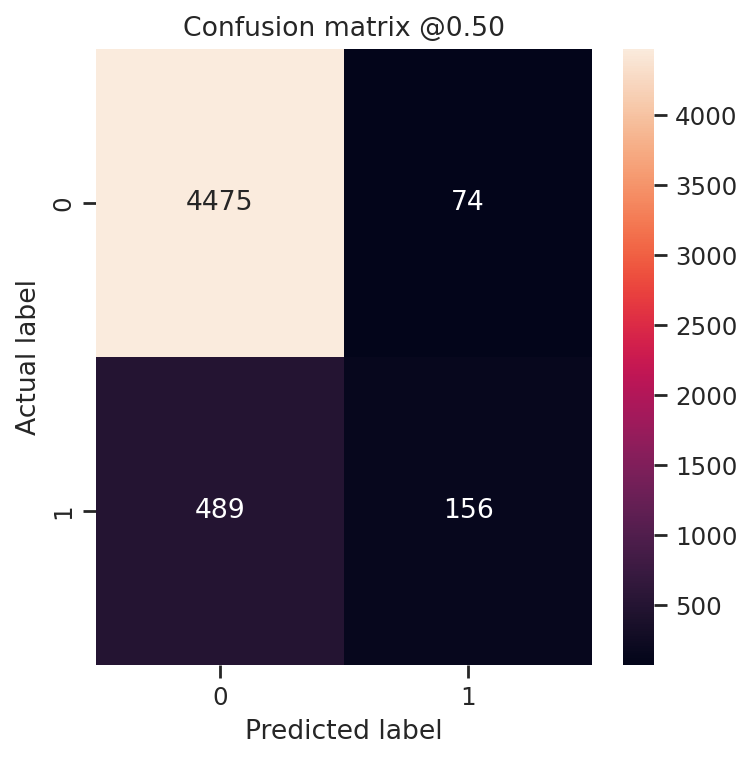

In [ ]:
# LightGBM - Valid
method = best_lgbm

y_prob = method.predict(lgbm_X_valid)
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_valid, y_pred)

(True Negatives):  9582
(False Positives):  198
(False Negatives):  993
(True Positives):  357
Total Actuall Subscribed:  1350


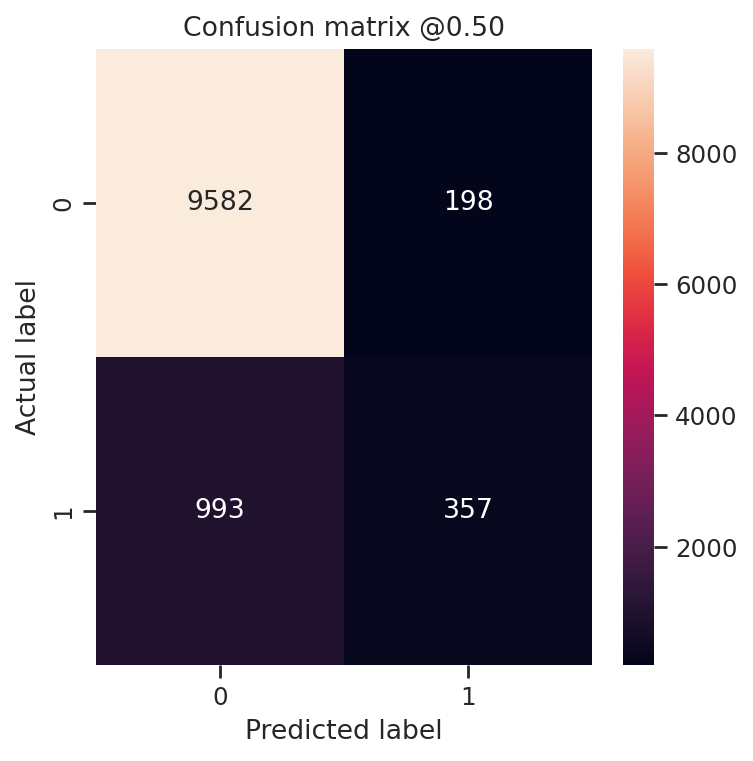

In [ ]:
# LightGBM - test
y_prob = method.predict(lgbm_X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_test, y_pred)

(True Negatives):  4466
(False Positives):  83
(False Negatives):  494
(True Positives):  151
Total Actuall Subscribed:  645


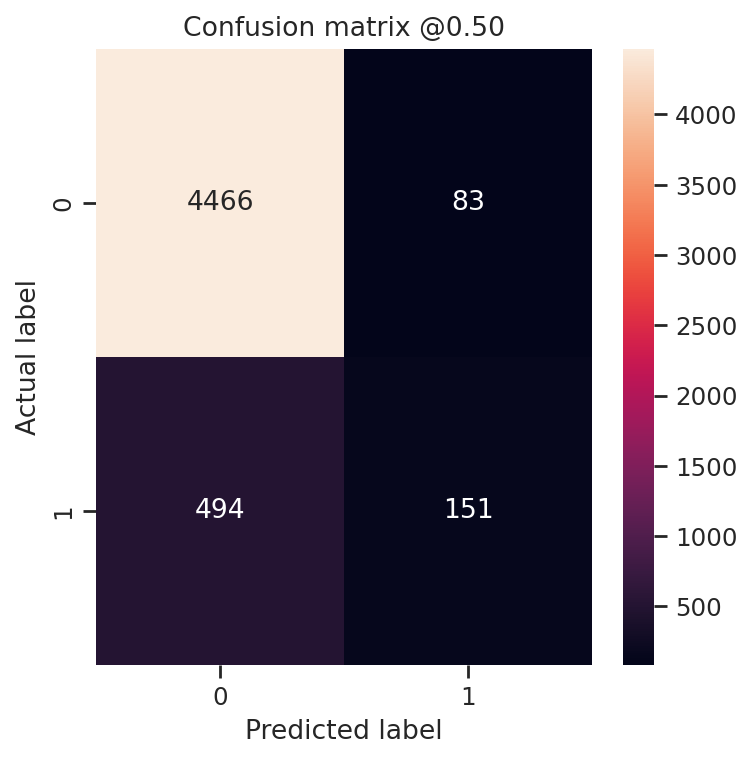

In [ ]:
# XGBoost
method = best_xgbst

y_prob = method.predict(xgb_valid_data)
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_valid, y_pred)

(True Negatives):  3985
(False Positives):  5795
(False Negatives):  150
(True Positives):  1200
Total Actuall Subscribed:  1350


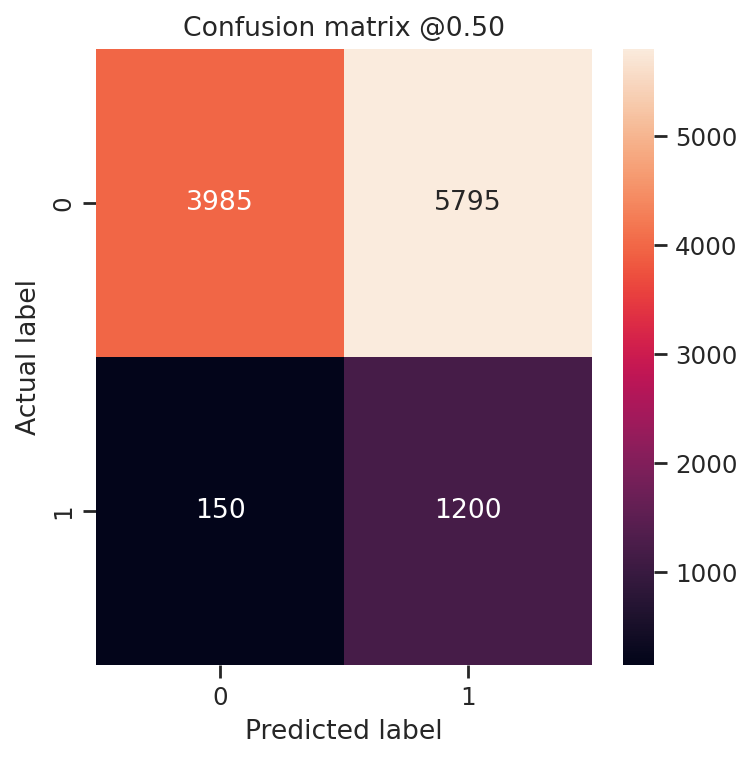

In [28]:
# XGBoost
method = best_xgbst

y_prob = method.predict(xgb_test_data)
y_pred = [1 if x >= 1/20 else 0 for x in y_prob]

plot_cm(y_test, y_pred)

# LightGBM -- Second iteration
The idea is to use the best parameter to select encoders again.

## Best encoder

In [ ]:
import lightgbm as lgb

lgbm_X_train = train[lightGBM_features].copy()
lgbm_X_valid = valid[lightGBM_features].copy()
lgbm_X_test = test[lightGBM_features].copy()



y_train = train['y']
y_valid = valid['y']
y_test = test['y']



lgbm_train_data = lgb.Dataset(lgbm_X_train, y_train)
lgbm_valid_data = lgb.Dataset(lgbm_X_valid, y_valid, reference = lgbm_train_data)
lgbm_test_data = lgb.Dataset(lgbm_X_test, y_test, reference = lgbm_train_data)

NameError: ignored

In [ ]:
# Auxiliary code - important to understand but similar to previous tutorials
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score

def lgbm_test_encodings(algo, parameter, variables):

  results_df_dic = {}
  for x in nominal:

      rows = ['One-Hot encoding', 'Target encoder', 'Leave-one-out encoder', 
              'GLMM encoder', 'CatBoost encoder', 'Ordinal encoder']

      columns=['F1-score','Cross-entropy', 'Error Rate', 'AUC', 'Sensitivity', 'Specificity', 'Precision']

      results = pd.DataFrame(0.0, columns=columns, index=rows)
    

      y_prob = np.zeros((len(y_valid), len(rows)))
      for i in range(len(rows)):
        if i == 5 and x != 'education':
          continue
        feature = []
        if i==0:
            feature = variables + globals()['%s_OneHot' % x]
        elif i==1: 
            feature = variables + [x+'TE'] 
        elif i==2:
            feature = variables + [x+'LeaveOneOut']
        elif i==3: 
            feature = variables + [x+'GLMM']
        elif i==4: 
            feature = variables + [x+'CatBoost']  
        if x == 'education':
          if i==5:
            feature = variables + ['educationOrdinal']
        
        X_train = train[feature]
        X_valid = valid[feature]

        lgbm_train = lgb.Dataset(X_train, y_train)
        lgbm_valid = lgb.Dataset(X_valid, y_valid, reference = lgbm_train)

        model = algo
        models = model.train(parameter, lgbm_train, num_boost_round=1000)

        # validation set predictions
        
        # y_prob[:, i] = model.predict_proba(X_valid)[:, 1]
        # y_pred = model.predict(X_valid)

        y_prob = models.predict(X_valid)
        y_pred = [1 if x >= 0.5 else 0 for x in y_prob]
              
        tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

        results.iloc[i,0] =  f1_score(y_valid, y_pred)  #f1-score
        results.iloc[i,1] =  log_loss(y_valid, y_prob)   # Cross entropy
        results.iloc[i,2] =   1 - accuracy_score(y_valid, y_pred)   # Error rate
        results.iloc[i,3] =  roc_auc_score(y_valid, y_prob)   # AUC
        results.iloc[i,4] =  tp/(tp+fn)   # Sensitivity 
        results.iloc[i,5] =  tn/(tn+fp)   # Specificity	
        results.iloc[i,6] =  precision_score(y_valid, y_pred)   # Precision
        

      # results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
      # results.iloc[i,1] =  tp/(tp+fn)
      # results.iloc[i,2] =  tn/(tn+fp)
      # results.iloc[i,3] =  precision_score(y_valid, y_pred)
      # results.iloc[i,4] =  roc_auc_score(y_valid, y_prob)
      # results.iloc[i,5] =  log_loss(y_valid, y_prob)
      # results.iloc[i,6] =  f1_score(y_valid, y_pred)  #f1-score


      if x not in results_df_dic:
          results_df_dic[x] = results
  return results_df_dic

In [ ]:
best_params = { 'objective': 'binary',
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 30,
                'lambda_l1': 2.4383347279286873,
                'lambda_l2': 8.379567222405476e-06,
                'bagging_fraction': 0.8709550987623199,
                'bagging_freq': 5,
                'feature_fraction': 0.5094556488498354,
                'min_data_in_leaf': 25,
                'feature_pre_filter': False,
                'verbosity': -1}

results_df_dic = lgbm_test_encodings(lgb, best_params, features)

NameError: ignored

In [ ]:
for key in results_df_dic:
    print(key)
    display(results_df_dic[key].sort_values(by=['F1-score'], ascending = [0]).round(5))

job


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.32515,0.29811,0.11109,0.78132,0.21550,0.98439,0.66190
Target encoder,0.32356,0.29862,0.11109,0.78018,0.21395,0.98461,0.66346
Leave-one-out encoder,0.32356,0.29862,0.11109,0.78018,0.21395,0.98461,0.66346
GLMM encoder,0.32356,0.29862,0.11109,0.77967,0.21395,0.98461,0.66346
CatBoost encoder,0.32356,0.29862,0.11109,0.78018,0.21395,0.98461,0.66346
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


marital


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
GLMM encoder,0.32235,0.29823,0.11090,0.78226,0.21240,0.98505,0.66829
Target encoder,0.32038,0.29819,0.11109,0.78184,0.21085,0.98505,0.66667
Leave-one-out encoder,0.32038,0.29819,0.11109,0.78184,0.21085,0.98505,0.66667
CatBoost encoder,0.32038,0.29819,0.11109,0.78184,0.21085,0.98505,0.66667
One-Hot encoding,0.31877,0.29835,0.11109,0.78220,0.20930,0.98527,0.66832
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


education


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Ordinal encoder,0.32000,0.29908,0.11128,0.77849,0.21085,0.98483,0.66341
Target encoder,0.31925,0.29894,0.11167,0.77989,0.21085,0.98439,0.65700
Leave-one-out encoder,0.31925,0.29894,0.11167,0.77989,0.21085,0.98439,0.65700
GLMM encoder,0.31925,0.29894,0.11167,0.77989,0.21085,0.98439,0.65700
CatBoost encoder,0.31925,0.29894,0.11167,0.77989,0.21085,0.98439,0.65700
One-Hot encoding,0.31604,0.29846,0.11167,0.77942,0.20775,0.98483,0.66010


month


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
One-Hot encoding,0.32,0.29849,0.11128,0.78033,0.21085,0.98483,0.66341
Target encoder,0.32,0.29826,0.11128,0.78135,0.21085,0.98483,0.66341
Leave-one-out encoder,0.32,0.29826,0.11128,0.78135,0.21085,0.98483,0.66341
GLMM encoder,0.32,0.29826,0.11128,0.78135,0.21085,0.98483,0.66341
CatBoost encoder,0.32,0.29826,0.11128,0.78135,0.21085,0.98483,0.66341
Ordinal encoder,0.00,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


day_of_week


,F1-score,Cross-entropy,Error Rate,AUC,Sensitivity,Specificity,Precision
Target encoder,0.32596,0.29662,0.11147,0.78117,0.21705,0.98373,0.65421
Leave-one-out encoder,0.32596,0.29662,0.11147,0.78117,0.21705,0.98373,0.65421
GLMM encoder,0.32596,0.29662,0.11147,0.78117,0.21705,0.98373,0.65421
CatBoost encoder,0.32596,0.29662,0.11147,0.78117,0.21705,0.98373,0.65421
One-Hot encoding,0.32093,0.29716,0.11244,0.78023,0.21395,0.98307,0.64186
Ordinal encoder,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


- job: one-hot
- marital: GLMM
- education: ordinal
- month: one-hot
- day_of_week: CatBoost encoder

In [ ]:
lightGBM_features_2nd = features  + ['educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost'] + job_OneHot + month_OneHot + binary_dummies 

## Hyperparameter tunning

In [16]:
import lightgbm as lgb

lightGBM_features_2nd = features  + ['educationOrdinal', 
                                     'maritalGLMM', 
                                     'day_of_weekCatBoost'] + job_OneHot + month_OneHot + binary_dummies 

lgbm_X_train_2nd = train[lightGBM_features_2nd].copy()
lgbm_X_valid_2nd = valid[lightGBM_features_2nd].copy()
lgbm_X_test_2nd = test[lightGBM_features_2nd].copy()



y_train = train['y']
y_valid = valid['y']
y_test = test['y']



lgbm_train_data_2nd = lgb.Dataset(lgbm_X_train_2nd, y_train)
lgbm_valid_data_2nd = lgb.Dataset(lgbm_X_valid_2nd, y_valid, reference = lgbm_train_data_2nd)
lgbm_test_data_2nd = lgb.Dataset(lgbm_X_test_2nd, y_test, reference = lgbm_train_data_2nd)

In [ ]:
# We have to reconstruct the dataset to tune min_data_in_leaf
from optuna.samplers import TPESampler


def objective(trial):
    
    params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01, 
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    'feature_pre_filter': False,
    'verbosity': -1
     }
    
    # Cross-validation 
    history = lgb.cv(params, lgbm_train_data_2nd, num_boost_round = 1000, 
                     nfold = 10, stratified = False, early_stopping_rounds = 50, verbose_eval=0)
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['binary_logloss-mean']))
    
    return history['binary_logloss-mean'][-1] # returns CV error for the best trial

sampler = TPESampler(seed = 7) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=2000, timeout = 10000)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2023-05-12 23:10:18,269] A new study created in memory with name: no-name-a73e55bd-c5e5-459a-9fc1-f4e8a2448576
[I 2023-05-12 23:10:34,353] Trial 0 finished with value: 0.29304545353993156 and parameters: {'num_leaves': 6, 'lambda_l1': 0.10453678278574731, 'lambda_l2': 8.824357269705966e-05, 'bagging_fraction': 0.8617325889154706, 'bagging_freq': 10, 'feature_fraction': 0.7692479352052168, 'min_data_in_leaf': 65}. Best is trial 0 with value: 0.29304545353993156.
[I 2023-05-12 23:10:52,227] Trial 1 finished with value: 0.29286303324959256 and parameters: {'num_leaves': 6, 'lambda_l1': 2.605858448423918e-06, 'lambda_l2': 0.0003154586986665377, 'bagging_fraction': 0.8396149980604702, 'bagging_freq': 9, 'feature_fraction': 0.6904705665742692, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.29286303324959256.
[I 2023-05-12 23:11:07,786] Trial 2 finished with value: 0.2918421196462071 and parameters: {'num_leaves': 20, 'lambda_l1': 1.5358250592890428, 'lambda_l2': 8.326609203905651e-

In [ ]:
lgbm_params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
lgbm_params

Number of boosting iterations: 330 

Best parameters:


{'objective': 'binary',
 'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'num_leaves': 52,
 'lambda_l1': 2.2030616724851644,
 'lambda_l2': 1.5024693910839652e-05,
 'bagging_fraction': 0.7084097604922667,
 'bagging_freq': 3,
 'feature_fraction': 0.5098044310206338,
 'min_data_in_leaf': 14,
 'feature_pre_filter': False,
 'verbosity': -1}

## Best LightGBM

In [ ]:
## Best Boosting  1st
# Best parameters:
# {'objective': 'binary',
#  'boosting_type': 'gbdt',
#  'learning_rate': 0.01,
#  'num_leaves': 44,
#  'lambda_l1': 2.3940244060036417,
#  'lambda_l2': 8.243998317794096e-08,
#  'bagging_fraction': 0.7165092950708541,
#  'bagging_freq': 3,
#  'feature_fraction': 0.5253096835972446,
#  'min_data_in_leaf': 17,
#  'feature_pre_filter': False,
#  'verbosity': -1}


## 2nd Number of boosting iterations: 330 

# Best parameters:
# {'objective': 'binary',
#  'boosting_type': 'gbdt',
#  'learning_rate': 0.01,
#  'num_leaves': 52,
#  'lambda_l1': 2.2030616724851644,
#  'lambda_l2': 1.5024693910839652e-05,
#  'bagging_fraction': 0.7084097604922667,
#  'bagging_freq': 3,
#  'feature_fraction': 0.5098044310206338,
#  'min_data_in_leaf': 14,
#  'feature_pre_filter': False,
#  'verbosity': -1}

In [17]:
# Best parameters
import lightgbm as lgb

## 1st
best_params1 = { 'objective': 'binary',
                'boosting_type': 'gbdt',
                'learning_rate': 0.01,
                'num_leaves': 44,
                'lambda_l1': 2.3940244060036417,
                'lambda_l2': 8.243998317794096e-08,
                'bagging_fraction': 0.7165092950708541,
                'bagging_freq': 3,
                'feature_fraction': 0.5253096835972446,
                'min_data_in_leaf': 17,
                'feature_pre_filter': False,
                'verbosity': -1}

## 2nd
best_params2 = {'objective': 'binary',
              'boosting_type': 'gbdt',
              'learning_rate': 0.01,
              'num_leaves': 52,
              'lambda_l1': 2.2030616724851644,
              'lambda_l2': 1.5024693910839652e-05,
              'bagging_fraction': 0.7084097604922667,
              'bagging_freq': 3,
              'feature_fraction': 0.5098044310206338,
              'min_data_in_leaf': 14,
              'feature_pre_filter': False,
              'verbosity': -1}

best_lgbm1 = lgb.train(best_params1, lgbm_train_data_2nd, num_boost_round=1000)
best_lgbm2 = lgb.train(best_params2, lgbm_train_data_2nd, num_boost_round=1000)

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['Best - LightBoost - Valid 1', 'Best - LightBoost - Valid 2']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[best_lgbm1, best_lgbm2]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    
    tau =1/20

    y_prob = method.predict(lgbm_X_test_2nd)
    y_pred = [1 if x >= tau else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_test, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_test, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_test, y_prob)
    results.iloc[i,5] =  log_loss(y_test, y_prob)
    results.iloc[i,6] =  f1_score(y_test, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)

,Error Rate,Sensitivity,Specificity,Precision,AUC,Cross-entropy,F1-score
Best - LightBoost - Valid 2,0.509,0.871,0.439,0.176,0.801,0.286,0.293
Best - LightBoost - Valid 1,0.515,0.879,0.431,0.176,0.801,0.286,0.293


In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('(True Negatives): ', cm[0][0])
    print('(False Positives): ', cm[0][1])
    print('(False Negatives): ', cm[1][0])
    print('(True Positives): ', cm[1][1])
    print('Total Actuall Subscribed: ', np.sum(cm[1]))

(True Negatives):  4465
(False Positives):  84
(False Negatives):  485
(True Positives):  160
Total Actuall Subscribed:  645


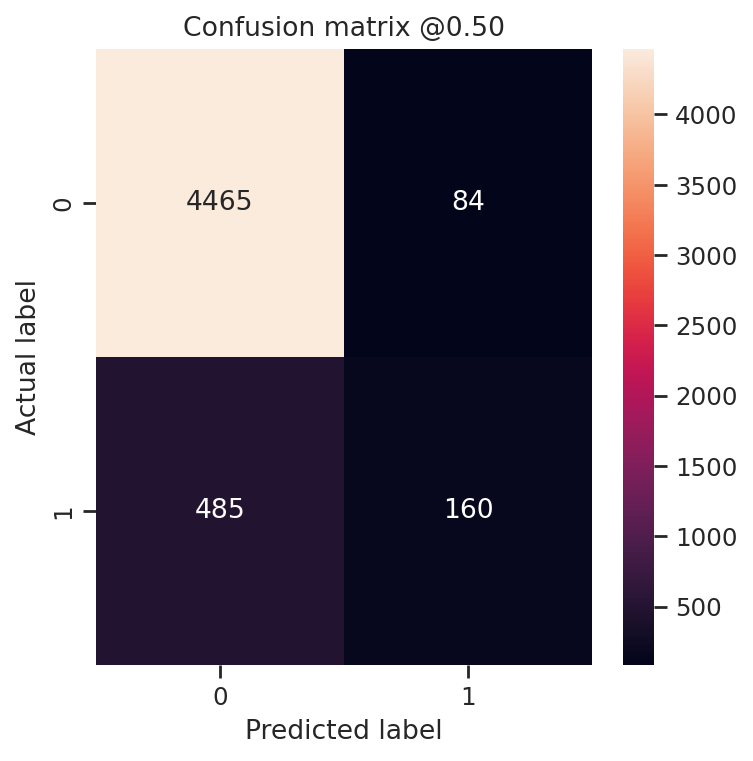

In [ ]:
# LightGBM - Valid
method = best_lgbm2

y_prob = method.predict(lgbm_X_valid_2nd)
y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

plot_cm(y_valid, y_pred)

(True Negatives):  4292
(False Positives):  5488
(False Negatives):  174
(True Positives):  1176
Total Actuall Subscribed:  1350


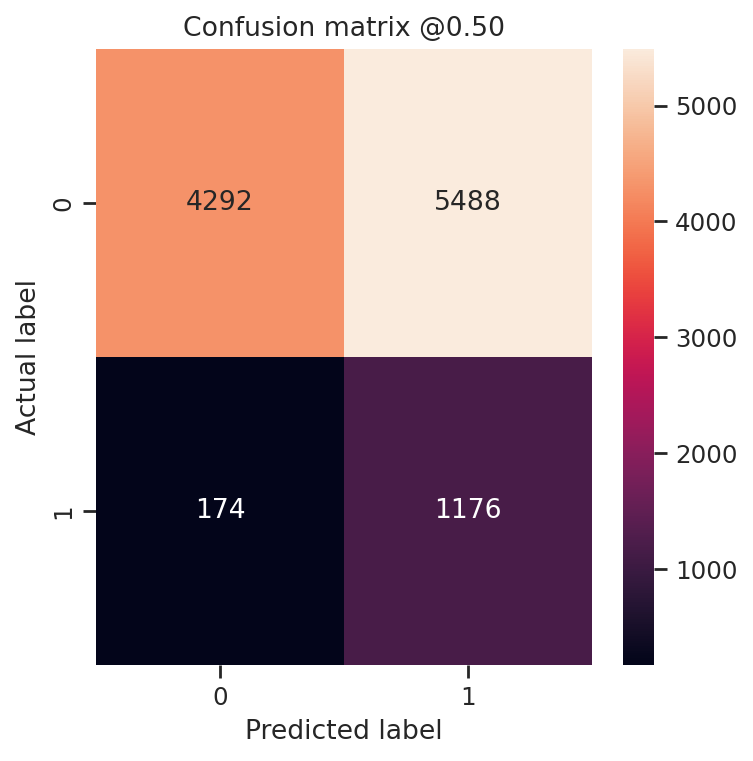

In [20]:
# LightGBM - Test
method = best_lgbm2

y_prob = method.predict(lgbm_X_test_2nd)
y_pred = [1 if x >= 0.05 else 0 for x in y_prob]

plot_cm(y_test, y_pred)


(True Negatives):  4292
(False Positives):  5488
(False Negatives):  174
(True Positives):  1176
Total Actuall Subscribed:  1350


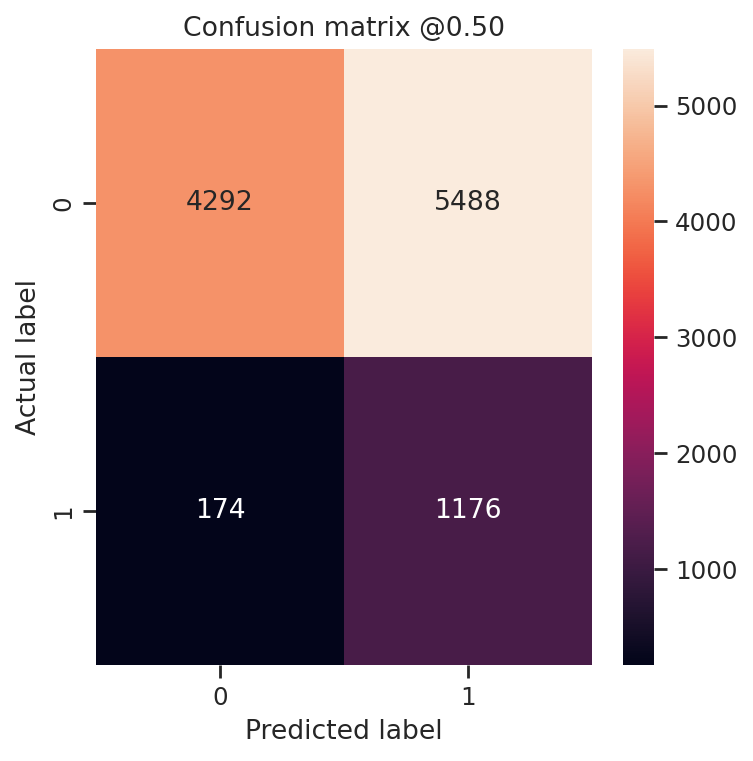

In [ ]:
lfp = 1
lfn = 19
tau = lfp/(lfp+lfn)

# # y_pred = decision_tree.predict(X_valid[feature_for_dt])
# y_prob = base_bag.predict_proba(valid[feature_for_bag])
# y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
# y_prob[y_prob > 1- 1e-5] =  1- 1e-5

# y_pred = (y_prob[:, 1] > tau).astype(int)



# LightGBM - Test
method = best_lgbm2

y_prob = method.predict(lgbm_X_test_2nd)
#y_pred = [1 if x >= 0.5 else 0 for x in y_prob]
y_pred = (y_prob > tau).astype(int)

plot_cm(y_test, y_pred)




## Feature imporatance


In [ ]:
def booster_plot_feature_importance(model, labels, max_features = 20):
    # feature_importance = model.feature_importances_*100
    feature_importance = model.feature_importance(importance_type='gain')
    feature_importance = 100*(feature_importance/np.max(feature_importance))
    table = pd.Series(feature_importance, index = labels).sort_values(ascending=True, inplace=False)
    fig, ax = fig, ax = plt.subplots(figsize=(9,6))
    if len(table) > max_features:
        table.iloc[-max_features:].T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    else:
        table.T.plot(kind='barh', edgecolor='black', width=0.7, linewidth=.8, alpha=0.9, ax=ax)
    ax.tick_params(axis=u'y', length=0) 
    ax.set_title('Variable importance', fontsize=13)
    sns.despine()
    return fig, ax

In [ ]:
lightGBM_features_2nd = features  + ['educationOrdinal', 'maritalGLMM', 'day_of_weekCatBoost'] + job_OneHot + month_OneHot + binary_dummies 

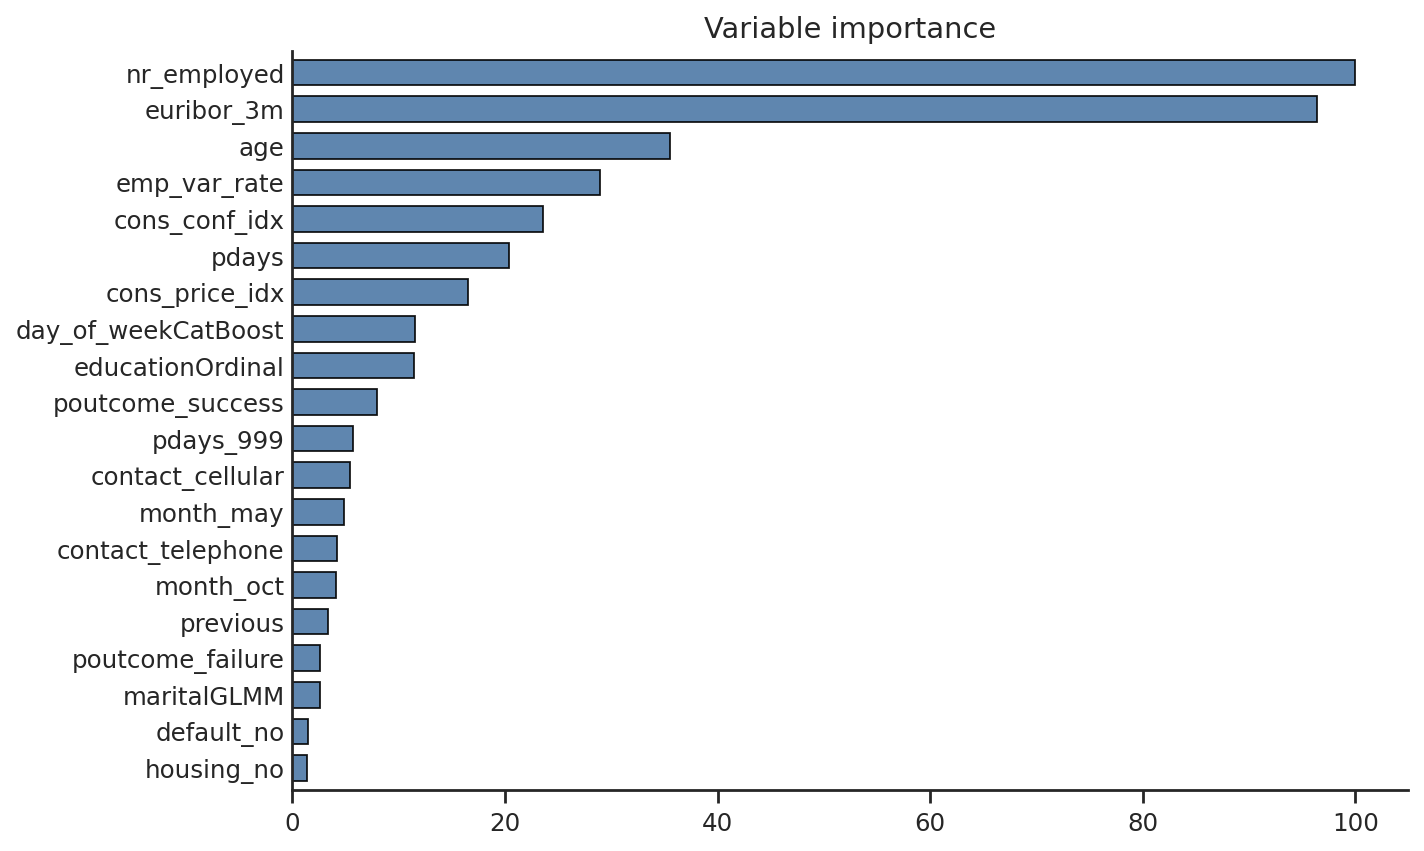

In [ ]:
model = best_lgbm2
booster_plot_feature_importance(model, labels=lightGBM_features_2nd)
plt.show()

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(best_lgbm2)
# xgb_X_test = test[xgBoost_features].copy()
shap_values_lgbm = explainer.shap_values(lgbm_X_test_2nd)

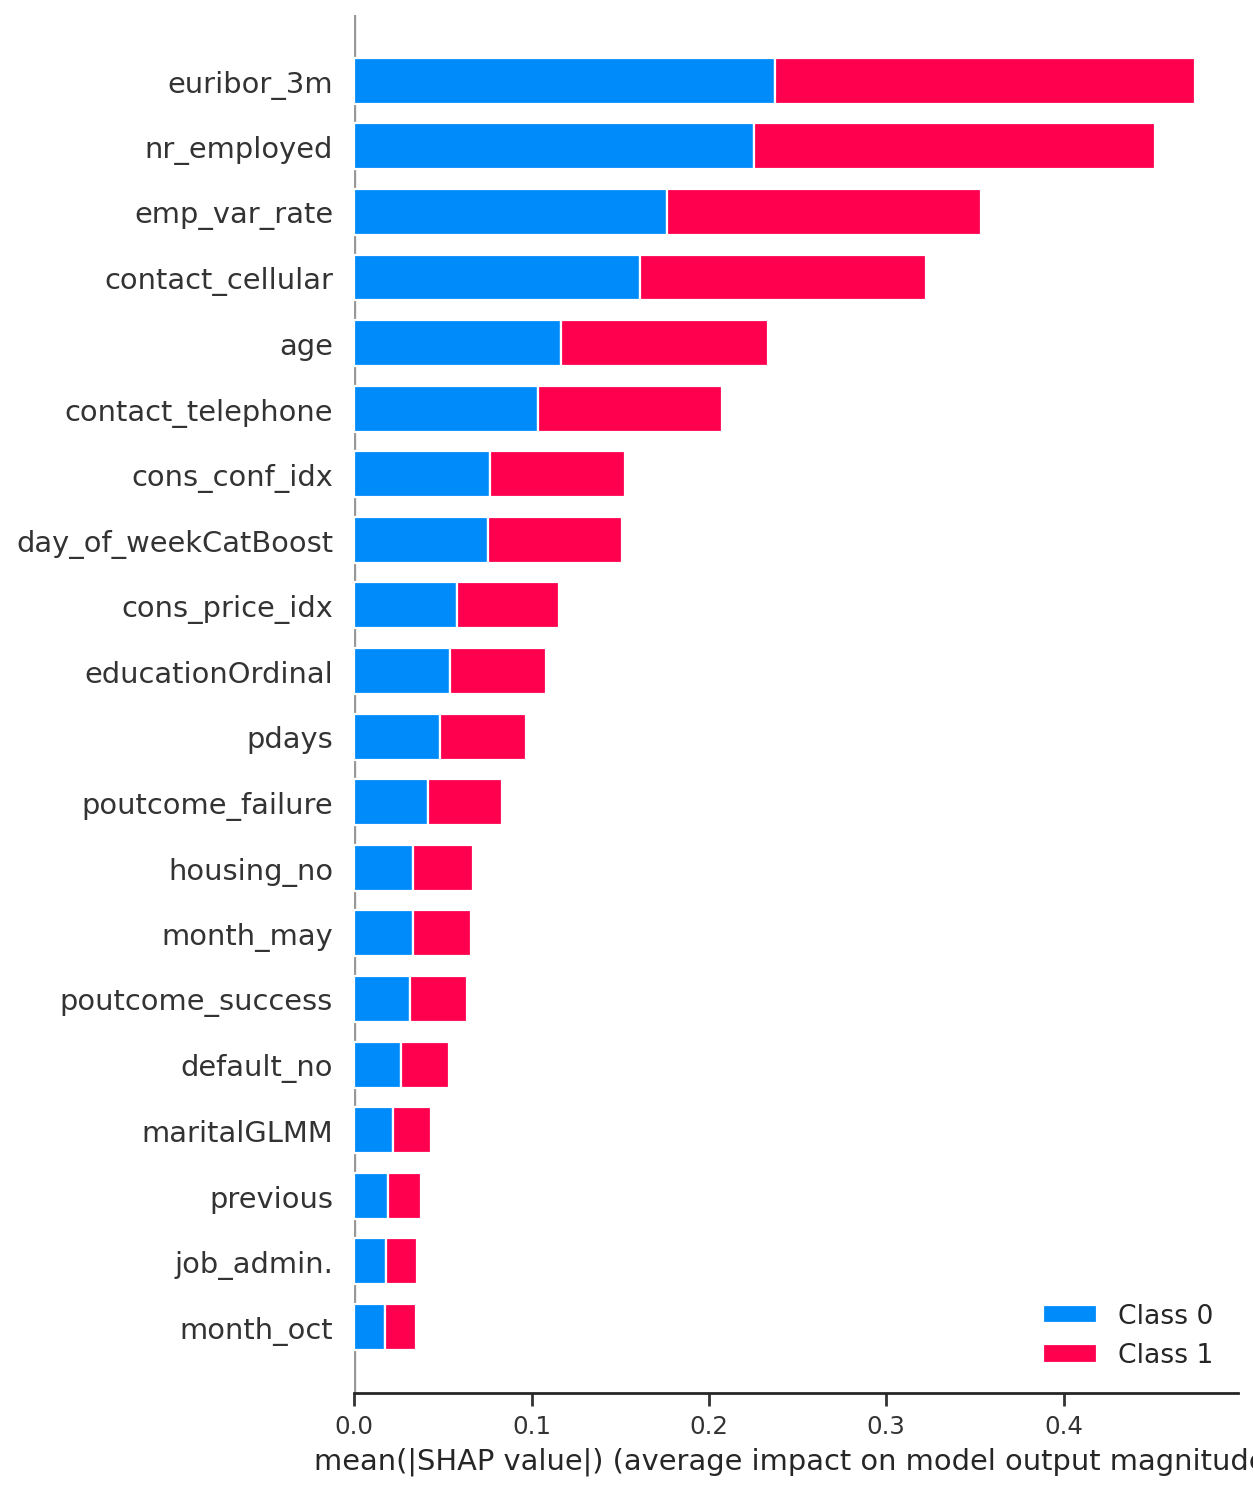

In [ ]:
shap.summary_plot(shap_values_lgbm, lgbm_X_test_2nd, feature_names=lgbm_X_test_2nd.columns)

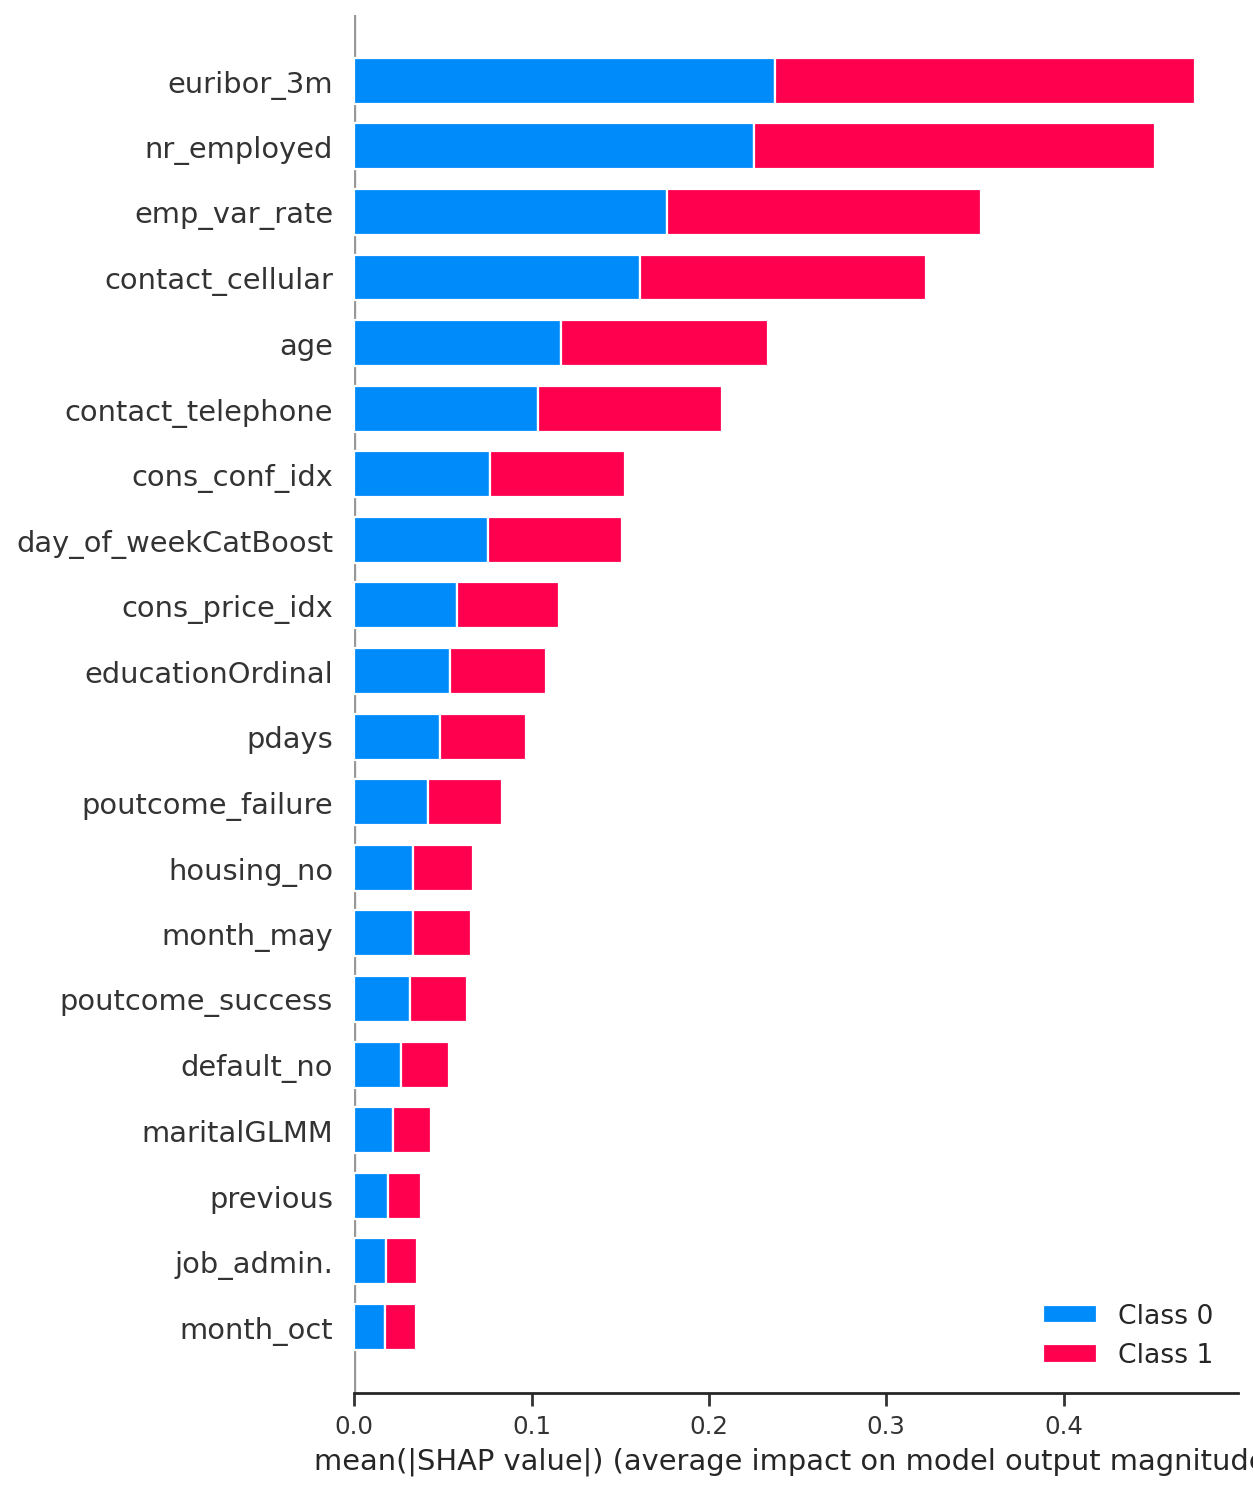

In [ ]:
shap.summary_plot(shap_values_lgbm, lgbm_X_test_2nd, plot_type = 'bar')

# 🥹🥹🥹🥹🥹🥹End of boosting

# By F1

In [ ]:
# We have to reconstruct the dataset to tune min_data_in_leaf
from optuna.samplers import TPESampler
def objective(trial):
    params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1),  # tune the learning rate
    'num_leaves': trial.suggest_int('num_leaves', 2, 64),
    'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
    'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
    'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    'feature_pre_filter': False,
    'verbosity': -1,
    'random_state': 7,  # for reproducibility,
    'metric': 'auc'
     }
    
    history = lgb.cv(params, lgbm_train_data_2nd, num_boost_round = 1000, 
                     nfold = 10, stratified = True, early_stopping_rounds = 50, verbose_eval=0)
    
    trial.set_user_attr('params', params)
    trial.set_user_attr('num_boost_round', len(history['auc-mean']))

    return max(history['auc-mean'])  # return the best f1 score, not necessarily the last one

sampler = TPESampler(seed = 7) 
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=1000, timeout = 3600)  # reduced the number of trials and timeout for practicality

[I 2023-05-20 05:12:33,453] A new study created in memory with name: no-name-c1eb2fa5-190d-4da1-ad17-363cd7f8e9e1
[I 2023-05-20 05:12:51,996] Trial 0 finished with value: 0.7949878922308496 and parameters: {'learning_rate': 0.001694044709524274, 'num_leaves': 51, 'lambda_l1': 8.824357269705966e-05, 'lambda_l2': 0.032447900418063655, 'bagging_fraction': 0.9889947559983013, 'bagging_freq': 6, 'feature_fraction': 0.7505602318299689, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.7949878922308496.
[I 2023-05-20 05:13:08,442] Trial 1 finished with value: 0.7965777694430545 and parameters: {'learning_rate': 0.0063872944941386735, 'num_leaves': 33, 'lambda_l1': 0.012973882641375565, 'lambda_l2': 0.17125818022724254, 'bagging_fraction': 0.6904705665742692, 'bagging_freq': 1, 'feature_fraction': 0.6440727996539968, 'min_data_in_leaf': 117}. Best is trial 1 with value: 0.7965777694430545.
[I 2023-05-20 05:13:31,658] Trial 2 finished with value: 0.7977942378755838 and parameters: {'learni

KeyboardInterrupt: ignored

In [ ]:
lgbm_params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
lgbm_params

In [ ]:
# Best parameters
import lightgbm as lgb

best_lgbm_auc = lgb.train(lgbm_params, lgbm_train_data_2nd, num_boost_round=1000)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss, recall_score, f1_score


columns=['Error Rate', 'Sensitivity', 'Specificity', 'Precision', 'AUC', 'Cross-entropy',
         'F1-score']
rows=['LightGBM - AUC']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[best_lgbm_auc]

y_prob = np.zeros((len(y_valid), len(rows)))

for i, method in enumerate(methods):
    

    y_prob = method.predict(xgb_valid_data)
    y_pred = [1 if x >= 0.5 else 0 for x in y_prob]

      
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel() 

    results.iloc[i,0] =   1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,1] =  tp/(tp+fn)
    results.iloc[i,2] =  tn/(tn+fp)
    results.iloc[i,3] =  precision_score(y_valid, y_pred)
    results.iloc[i,4] =  roc_auc_score(y_valid, y_prob)
    results.iloc[i,5] =  log_loss(y_valid, y_prob)
    results.iloc[i,6] =  f1_score(y_valid, y_pred)  #f1-score

results.sort_values(by=['F1-score'], ascending = [0]).round(3)